In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
import copy
from statsmodels.stats.sandwich_covariance import cov_hac as cov
import matplotlib.pyplot as plt
from scipy.stats import chi2
from arch import arch_model
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
def OLS(x, y, addcon=True, cov_type=None, sig_level=.05, summary=0, cov_kwds = None):
    """Wrapper for statsmodels OLS regression
    """
    if addcon:
        X = sm.add_constant(x)
    else:
        X = x
    if cov_type==None:
        ols_results = sm.OLS(y,X).fit(cov_type='nonrobust')
    else:
        ols_results = sm.OLS(y,X).fit(cov_type=cov_type, cov_kwds=cov_kwds)
     
    ### print out the OLS estimation results
    if summary==1:
        print(ols_results.summary())  
    
    ols_cov_mat  = cov(ols_results)
    ols_beta_hat = ols_results.params # beta_hat
    ols_resids   = ols_results.resid  # resids
    ols_se       = ols_results.bse
    ols_pvalues  = ols_results.pvalues

    return ols_beta_hat, ols_resids, ols_se, ols_cov_mat, ols_pvalues

def latex_table(df, caption="", label="", index=False):
    return "\\begin{table}[H]\n\centering\n"+df.to_latex(index=index)+"\caption{"+caption+"}\n\label{tab:"+label+"}\
            \n\end{table}"

In [3]:
def question_1_wrapper(data_name, print_OLS):
    '''
    data_name can be either 'SP', 'GE' or 'IBM'
    '''
    
    # Data
    data = pd.read_csv(data_name+'.csv')
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    data = data.set_index('Date')
    data = data.loc[data.index.astype(str) <= '2018-12-31'] # Every year and month are complete

    # Daily continuous returns (not scaled)
    Daily_Returns = []
    for i in range(len(data['Adj Close'])-1):
        Daily_Returns.append(np.log(data['Adj Close'][i+1]/data['Adj Close'][i]))
    data = data.iloc[1:]
    data['Daily Returns'] = Daily_Returns
    data = data.reset_index()
    
    # Annualized Volatility with Daily Data (Monthly)
    RV_annual_from_daily_monthly = []
    RV_List = [] # Daily returns in the month
    cur_month = data['Date'][0].month
    for i in range(len(data['Date'])):
        if data['Date'][i].month == cur_month and i < (len(data['Date'])-1):
            RV_List.append(data['Daily Returns'][i])
        else:
            if i == (len(data['Date']) - 1):
                RV_List.append(data['Daily Returns'][i])
            RV_annual_from_daily_monthly.append(np.sqrt(np.sum((np.array(RV_List))**2.0)))
            RV_List = []
            cur_month = data['Date'][i].month
            RV_List.append(data['Daily Returns'][i])
    RV_annual_from_daily_monthly_var = np.array(RV_annual_from_daily_monthly)**2
    RV_annual_from_daily_monthly = np.array(RV_annual_from_daily_monthly)
    RV_annual_from_daily_monthly_annualized = RV_annual_from_daily_monthly * np.sqrt(12)
    
    # Realized monthly volatility from daily data
    Monthly_Returns = []
    RV_monthly_from_daily = []
    RV_List = [] # Daily returns in the month
    cur_month = data['Date'][0].month
    Month_List = []
    for i in range(len(data['Date'])):
        if data['Date'][i].month == cur_month and i < (len(data['Date'])-1):
            RV_List.append(data['Daily Returns'][i])
        else:
            if i == (len(data['Date']) - 1):
                RV_List.append(data['Daily Returns'][i])
            return_for_the_month = np.sum(np.array(RV_List))
            Monthly_Returns.append(return_for_the_month)
            RV_monthly_from_daily.append(np.sqrt(return_for_the_month**2.0))
            RV_List = []
            Month_List.append(data['Date'][i])
            cur_month = data['Date'][i].month
            RV_List.append(data['Daily Returns'][i])
    RV_monthly_from_daily_var = np.array(RV_monthly_from_daily)**2
    RV_monthly_from_daily = np.array(RV_monthly_from_daily) * np.sqrt(12)
    
    # Realized volatility with daily returns
    RV_annual_from_daily_var = np.array((data['Daily Returns'])**2)
    RV_annual_from_daily = np.sqrt(np.array((data['Daily Returns'])**2)) * np.sqrt(252)

    # Output
    Daily_Returns = np.array(Daily_Returns)
    Monthly_Returns = np.array(Monthly_Returns)
    RV_annual_from_daily = np.array(RV_annual_from_daily)
    RV_annual_from_monthly = np.array(RV_monthly_from_daily)
    RV_annual_from_monthly_daily = np.array(RV_annual_from_daily_monthly)
    vol = RV_annual_from_monthly_daily
    
    # Comparisson
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(data['Date'], RV_annual_from_daily, label='Annual vol from daily returns')
    plt.plot(Month_List, RV_annual_from_monthly, label='Annual vol from monthly returns')
    plt.plot(Month_List, RV_annual_from_daily_monthly_annualized, label='Annual monthly vol from daily returns')
    plt.xlabel('Year')
    plt.ylabel('Volatility')
    plt.legend(loc='upper left')
    plt.show()

    # Fit AR(1)
    x = vol[0:len(vol)-1]
    y = vol[1:len(vol)]
    ols_beta_hat, ols_resids, ols_se, ols_cov_mat, ols_pvalues = OLS(x, y, addcon = True, summary = print_OLS)

    # Forecast
    y_hat = x*ols_beta_hat[1] + ols_beta_hat[0]
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(y, label='Realized')
    plt.plot(y_hat, label='Predicted')
    plt.legend()
    plt.xlabel('Months')
    plt.ylabel('Volatility %')
    plt.show()
    
    # Error
    mse = np.mean((y - y_hat)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y-y_hat))
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('Annualized Volatility with Daily Returns:', np.sqrt(np.mean(RV_annual_from_daily_var)) * np.sqrt(252))
    print('Annualized Volatility with Monthly Returns:', np.sqrt(np.mean(RV_monthly_from_daily_var)) * np.sqrt(12))
    print('Annualized Volatility with Monthly Vol and Daily Data:', np.sqrt(np.mean(RV_annual_from_daily_monthly_var)) * np.sqrt(12))
    
    
    return Monthly_Returns, RV_annual_from_monthly_daily

## Problem 1

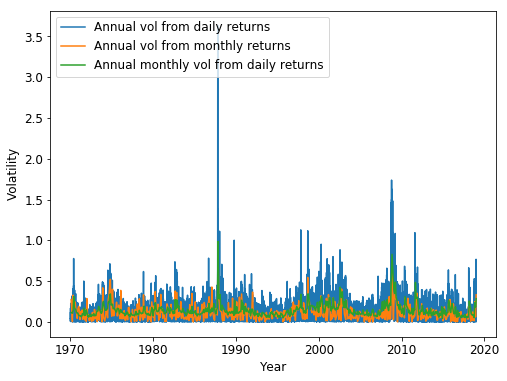

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     377.0
Date:                Wed, 15 May 2019   Prob (F-statistic):           3.44e-65
Time:                        22:37:28   Log-Likelihood:                 1493.4
No. Observations:                 587   AIC:                            -2983.
Df Residuals:                     585   BIC:                            -2974.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0157      0.002     10.029      0.0

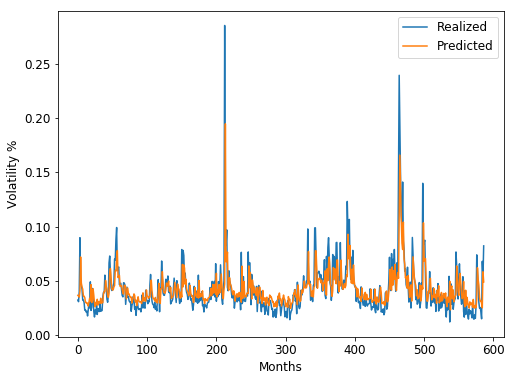

MSE: 0.00036122005150237944
RMSE: 0.019005789946813036
MAE: 0.010968749039436572
Annualized Volatility with Daily Returns: 0.16818403557750747
Annualized Volatility with Monthly Returns: 0.15267557334233467
Annualized Volatility with Monthly Vol and Daily Data: 0.16827254453869964


In [4]:
SP_returns, SP_vol = question_1_wrapper('SP', 1)

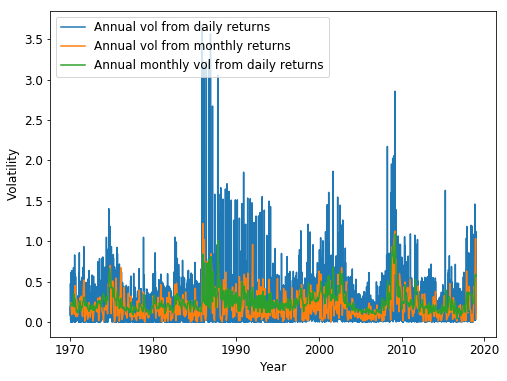

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     260.4
Date:                Wed, 15 May 2019   Prob (F-statistic):           1.01e-48
Time:                        22:37:31   Log-Likelihood:                 1168.0
No. Observations:                 587   AIC:                            -2332.
Df Residuals:                     585   BIC:                            -2323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.003     11.295      0.0

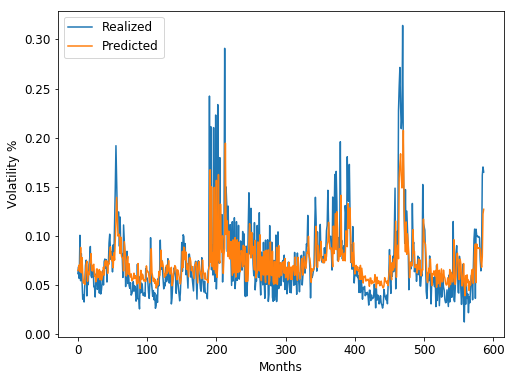

MSE: 0.0010943459149488828
RMSE: 0.033080899548665284
MAE: 0.02199152059292526
Annualized Volatility with Daily Returns: 0.2859189536300444
Annualized Volatility with Monthly Returns: 0.2731223941114715
Annualized Volatility with Monthly Vol and Daily Data: 0.2860694220706669


In [5]:
GE_returns, GE_vol = question_1_wrapper('GE', 1)

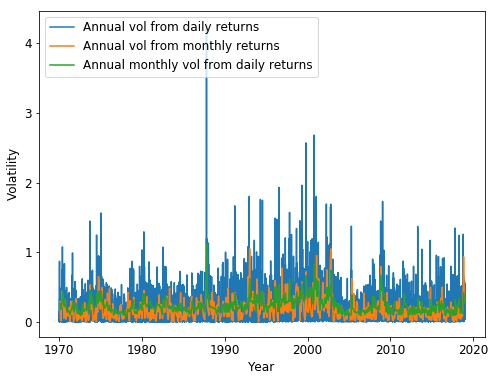

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     225.0
Date:                Wed, 15 May 2019   Prob (F-statistic):           2.84e-43
Time:                        22:37:33   Log-Likelihood:                 1270.8
No. Observations:                 587   AIC:                            -2538.
Df Residuals:                     585   BIC:                            -2529.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0318      0.003     12.104      0.0

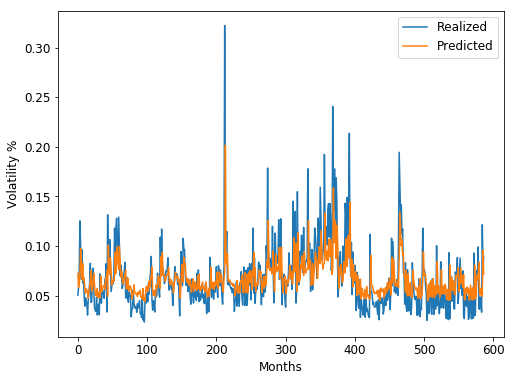

MSE: 0.0007711503591662113
RMSE: 0.027769594148388473
MAE: 0.018829690059106226
Annualized Volatility with Daily Returns: 0.25863424149889247
Annualized Volatility with Monthly Returns: 0.2468062143866231
Annualized Volatility with Monthly Vol and Daily Data: 0.25877035101704726


In [6]:
IBM_returns, IBM_vol = question_1_wrapper('IBM', 1)

## Problem 2

In [7]:
def question_2_3_wrapper(returns, realized_vol, p=1, o=0, q=1):
    '''
    p (int, optional) – Lag order of the symmetric innovation
    o (int, optional) – Lag order of the asymmetric innovation
    q (int, optional) – Lag order of lagged volatility or equivalent
    
    For GARCH: [p, o, q] = [1, 0, 1]
    For GJR-GARCH: [p, o, q] = [1, 1, 1]
    '''
    
    # Plot returns
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(returns)
    plt.xlabel('Months')
    plt.ylabel('Returns')
    plt.show()
    
    # GARCH (part a)
    GARCH_model = arch_model(returns, p=p, o=o, q=q)
    Res = GARCH_model.fit(update_freq = 5)
    conditional_vol = Res.conditional_volatility
    print('\n\n\n\n\n GARCH')
    print(Res)
    
    # Regression (part b)
    print('\n\n\n\n\n Regression')
    vol_beta, vol_resids, _, _, _ = OLS(conditional_vol, realized_vol, summary = 1)
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(realized_vol, label='Realized volatility')
    plt.plot(conditional_vol, label='Conditional volatility')
    plt.legend()
    plt.xlabel('Months')
    plt.ylabel('Volatility')

    # Error
    mse = np.mean((realized_vol - conditional_vol)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(realized_vol-conditional_vol))
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAE:', mae)

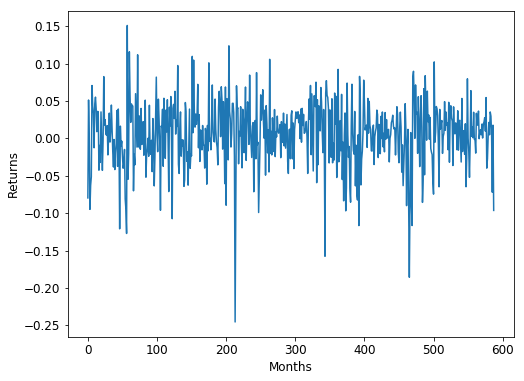

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1028.5391663334103
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2





 GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                1028.54
Distribution:                  Normal   AIC:                          -2049.08
Method:            Maximum Likelihood   BIC:                          -2031.57
                                        No. Observations:                  588
Date:                Wed, May 15 2019   Df Residuals:                      584
Time:                        22:37:34   Df Model:                            4
                                 Mean Model               

C:\Users\conan\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


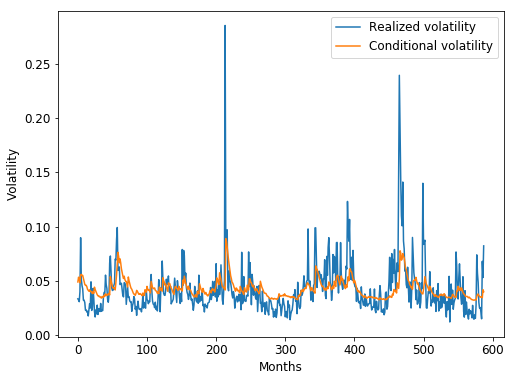

In [8]:
question_2_3_wrapper(SP_returns, SP_vol)

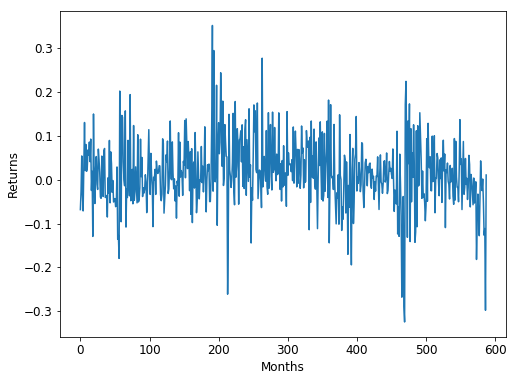

Iteration:      5,   Func. Count:     44,   Neg. LLF: -709.5464610335621
Iteration:     10,   Func. Count:     76,   Neg. LLF: -709.5994262569297
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -709.5994262567933
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10





 GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                709.599
Distribution:                  Normal   AIC:                          -1411.20
Method:            Maximum Likelihood   BIC:                          -1393.69
                                        No. Observations:                  588
Date:                Wed, May 15 2019   Df Residuals:                      584

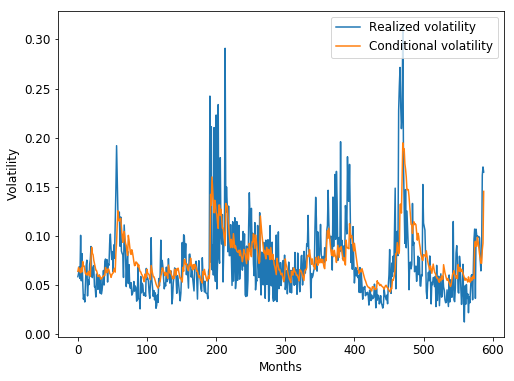

In [9]:
question_2_3_wrapper(GE_returns, GE_vol)

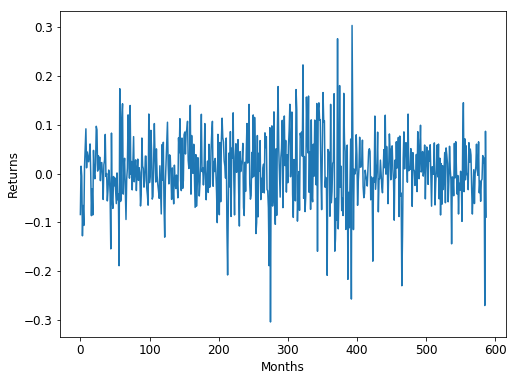

Iteration:      5,   Func. Count:     40,   Neg. LLF: -744.0163485046576
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -744.0373348127415
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9





 GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                744.037
Distribution:                  Normal   AIC:                          -1480.07
Method:            Maximum Likelihood   BIC:                          -1462.57
                                        No. Observations:                  588
Date:                Wed, May 15 2019   Df Residuals:                      584
Time:                        22:37:35   Df Model:                         

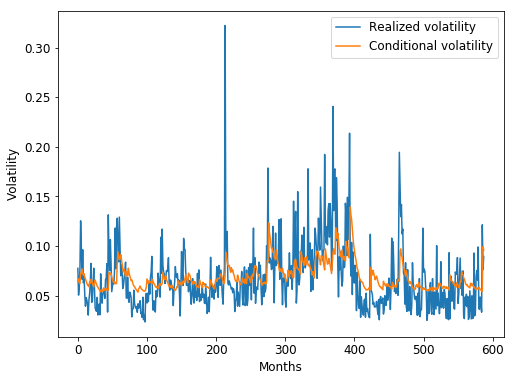

In [10]:
question_2_3_wrapper(IBM_returns, IBM_vol)

## Problem 3

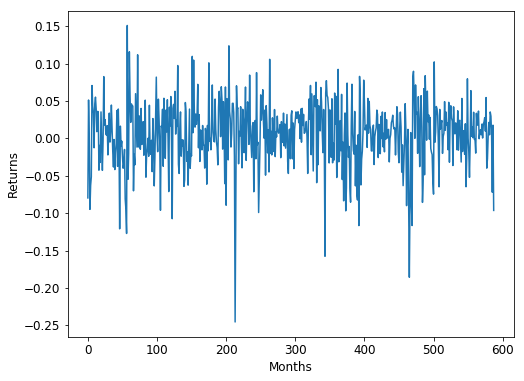

Iteration:      5,   Func. Count:     48,   Neg. LLF: -1033.2384143407485
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1033.4340740534335
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1033.4444615316143
            Iterations: 13
            Function evaluations: 109
            Gradient evaluations: 13





 GARCH
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                1033.44
Distribution:                  Normal   AIC:                          -2056.89
Method:            Maximum Likelihood   BIC:                          -2035.01
                                        No. Observations:                  588
Date:                Wed, May 15 2019   Df Residuals:                     

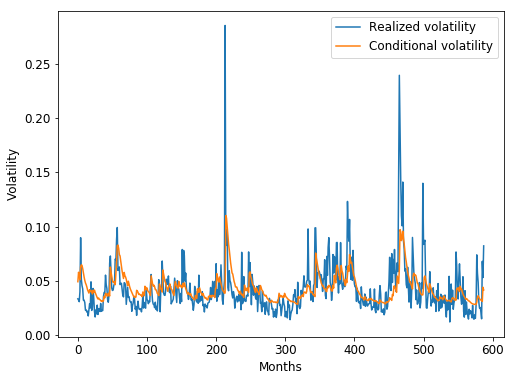

In [11]:
question_2_3_wrapper(SP_returns, SP_vol, p=1, o=1, q=1)

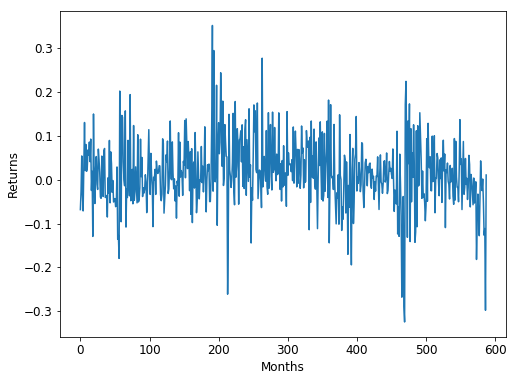

Iteration:      5,   Func. Count:     55,   Neg. LLF: -711.0202362292537
Iteration:     10,   Func. Count:     97,   Neg. LLF: -711.494028499884
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -711.508038708007
            Iterations: 14
            Function evaluations: 119
            Gradient evaluations: 13





 GARCH
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                711.508
Distribution:                  Normal   AIC:                          -1413.02
Method:            Maximum Likelihood   BIC:                          -1391.13
                                        No. Observations:                  588
Date:                Wed, May 15 2019   Df Residuals:                      583


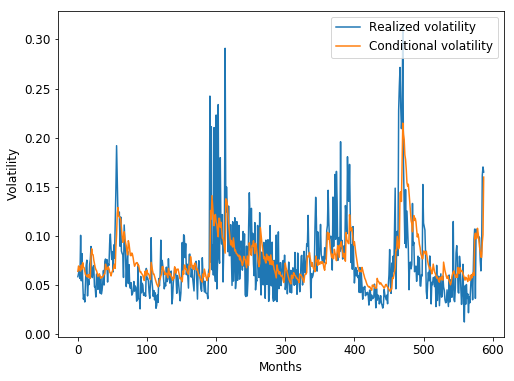

In [12]:
question_2_3_wrapper(GE_returns, GE_vol, p=1, o=1, q=1)

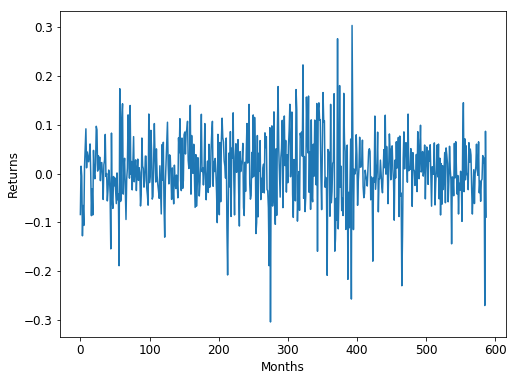

Iteration:      5,   Func. Count:     50,   Neg. LLF: -745.883298363608
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -745.8882723590806
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 8





 GARCH
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                745.888
Distribution:                  Normal   AIC:                          -1481.78
Method:            Maximum Likelihood   BIC:                          -1459.89
                                        No. Observations:                  588
Date:                Wed, May 15 2019   Df Residuals:                      583
Time:                        22:37:38   Df Model:                          

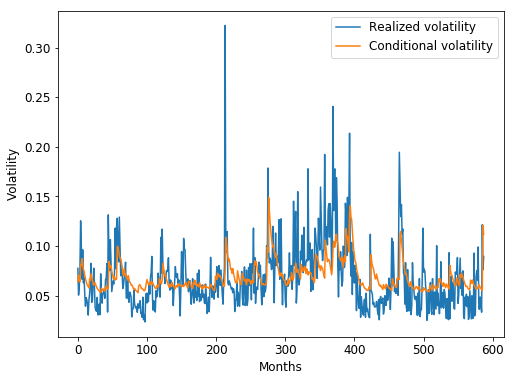

In [13]:
question_2_3_wrapper(IBM_returns, IBM_vol, p=1, o=1, q=1)